In [ ]:
# Tratar os dados textuais.

# Ter sempre o repositório sobre o Seaborn em mãos.

<h1 style='font-size:40px'> Employee Turnover Predicting Model</h1>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            This project aims to build a binary classifier that correctly predicts if a given employee is going to stay or quit the company.
        </li>
        <li> 
            The dataset used was encountered in a <a href='https://www.coursera.org/projects/employee-turnover-scikit-learn'>Coursera Guided Project</a>. Nonetheless, I've decided to produce my own solution to the case, which is different from the platform instructor's.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Loading the Data</h2>

In [44]:
import pandas as pd
import numpy as np

# Since I am looking to create more columns to the DF, I'll modify the maximum number of columns that can be displayed.
pd.set_option('max_columns', None)

# Importing the employee data.
employee_data = pd.read_csv('employee_data.csv')
employee_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [47]:
# Searching for anomalies in the data. All features do not present any null value and have its proper data type assigned.
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


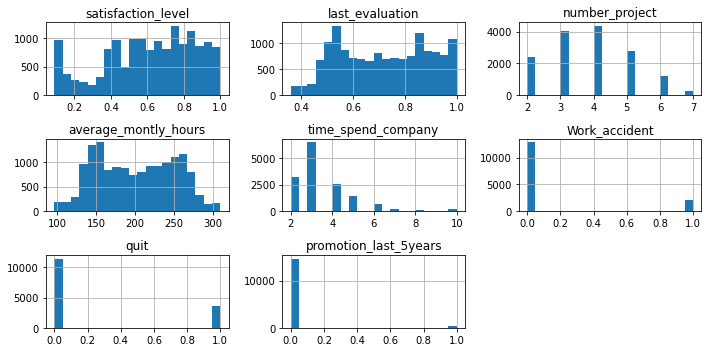

In [54]:
# Plotting a histograms frame looking for outliers.
employee_data.hist(bins=20, figsize=(10,5));
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <strong>> Mudar isso aqui! Falar mais sobre a importância de se ter trabalhadores experientes na empresa.</strong>
        <li> 
            The number of people who've spent more than 7 years in the enterprise looks proportionately very small. It could be a potential indicator for disconsidering them in model training. However, when we directly check the dataset, we can see that more than 350 workers are in accordance to such condition. It would be adequate to make an algorithm that neglects the reality of such number of employees? I don't think so.
        </li>
        <li> 
            Also, it is worth acknowledging that we are dealing with a dataset with a unbalanced quantity of target values. The great amount of 0's will likely make it easier to the models to correctly identify them. Conversely, the lower number of 1's requires a higher efficiency of the algorithms to apprehend the patterns among tha class' instances.
        </li>
    </ul>
</div>

In [63]:
# The well-experienced people will be kept in the dataset.
print(len(employee_data[employee_data.time_spend_company>7]))

376


<h2 style='font-size:30px'> Training and Test Sets</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Since salary is one of the main aspects considered when someone is deciding to stay or leave their enterprise, I'll attempt to maintain the proportions of such feature. Fortunately, that is already labeled as categories so we don't need to encode any of its values.
        </li>
    </ul>
</div>

In [225]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(employee_data, employee_data.salary):
    train = employee_data.loc[train_index]
    test = employee_data.loc[test_index]

<h2 style='font-size:30px'> Exploratory Analysis on the Training Data</h2>

<h3 style='font-size:30px;font-style:italic'> Adding new stats</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Before diving into the data examination, it is interesting to use the data we already have in order to generate new stats that might be prove useful to our models.
        </li>
        <li> 
            The new columns to be added are:
            <ul style='list-style-type:lower-alpha'>
                <li> No of projects per years of work.</li>
                <li> Harmonic mean between the satisfaction levels and last evaluation.</li>
            </ul>
        </li>
    </ul>
</div>

In [230]:
from scipy.stats import hmean
train['number_project_per_time_spend'] = train.number_project / train.time_spend_company

# Using harmonic mean can highlight possible discrepancies between the values. For instance, a given worker might be very unsatisfied (0.2)
# with the company, whereas their boss and team exceedingly enjoy working with them (0.9).

# We'll name this stat as 'reciprocity_degree'
train['reciprocity_degree'] = hmean([train.satisfaction_level, train.last_evaluation])

<h3 style='font-size:30px;font-style:italic'> Densities of staying or quitting occurences according to satisfaction and salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The violin plot below exposes, among every salary category, the densities of quitting and staying occurences for every satisfaction degree measured.
        </li>
        <li> 
            In all cases, employees with contentment levels lower than 50% tend to abandon the company.
        </li>
    </ul>
</div>

<AxesSubplot:xlabel='salary', ylabel='satisfaction_level'>

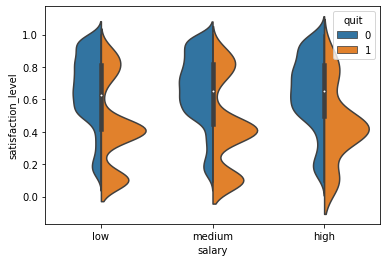

In [228]:
sns.violinplot(data=train, x='salary', y='satisfaction_level', hue='quit',split=True, order=['low', 'medium', 'high'])

<h3 style='font-size:30px;font-style:italic'> Reciprocity scores per Department and Salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Now, we are zooming in the analysis about salary and satisfaction scores adding the Department feature.
        </li>
    </ul>
</div>

In [232]:
# Segregating the employees who've quitted and still work in the company
only_0=train[train.quit==0]
only_1=train[train.quit==1]

In [235]:
# Sorting the pivot tables by 'hr' and 'support' so the index order could be ['low', 'medium', 'high']
recip0 = pd.pivot_table(data = only_0, index='salary', columns='department', values='reciprocity_degree').sort_values(by='hr')
recip1 = pd.pivot_table(data = only_1, index='salary', columns='department', values='reciprocity_degree').sort_values(by='support')

Text(767.7272727272725, 0.5, '')

<Figure size 720x288 with 0 Axes>

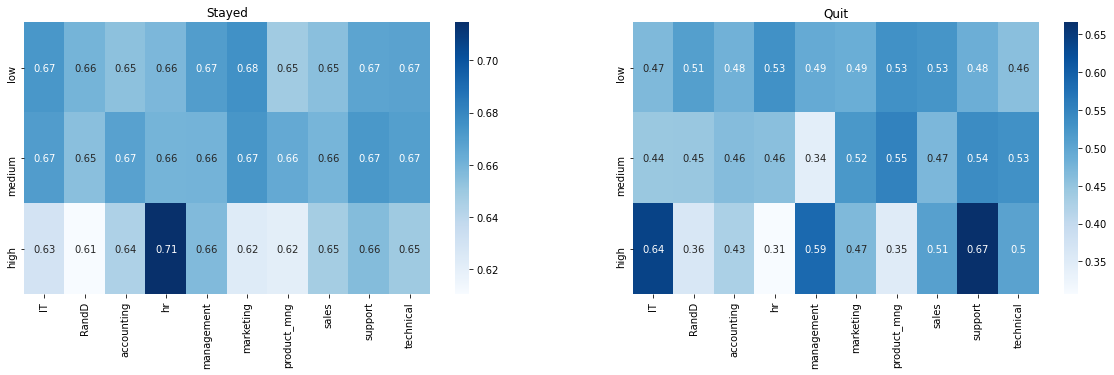

In [236]:
import seaborn as sns
plt.figure(figsize=(10,4))
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.heatmap(recip0, cmap='Blues', annot=True)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Stayed')
plt.subplot(122)
sns.heatmap(recip1, cmap='Blues', annot=True)
plt.title('Quit')
plt.xlabel(None)
plt.ylabel(None)

<div> 
    <ul style='font-size:20px'> 
        <li> 
            Some pretty interesting insights on both heatmaps. People with high incomes from IT and Support areas who've left their jobs actually had a pretty decent reciprocity levels. They were probably glad with their roles so as their team was with their performance. So what could possibly persuade them to leave?
        </li>
    </ul>
</div>

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'>Checking out the potential quitting outliers from the IT department </h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Here, we can see the reason for the high reciprocity levels for the IT area. Two of its leaving workers had pretty high scores.
        </li>
        <li> 
            Since it is unusual for someone in that condition to decide to leave the company, it is necessary to analyze whether we can find another reason for the departure. If not, we'll consider those employees as noise in the data.
        </li>
    </ul>
</div>

In [268]:
# Checking out the potential quitting outliers from the IT department. There are two people with reciprocity levels higher than 0.8
quit_it = only_1[(only_1['department']=='IT') & (only_1['salary']=='high')]
quit_it

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,number_project_per_time_spend,reciprocity_degree
1281,0.75,0.88,5,270,5,0,1,0,IT,high,1.000000,0.809816
1515,0.72,0.99,5,257,5,0,1,0,IT,high,1.000000,0.833684
1359,0.46,0.46,2,145,3,0,1,0,IT,high,0.666667,0.460000
1437,0.40,0.53,2,155,3,0,1,0,IT,high,0.666667,0.455914


In [305]:
quit_it[quit_it['reciprocity_degree']>0.8].mean()

satisfaction_level                 0.73500
last_evaluation                    0.93500
number_project                     5.00000
average_montly_hours             263.50000
time_spend_company                 5.00000
Work_accident                      0.00000
quit                               1.00000
promotion_last_5years              0.00000
number_project_per_time_spend      1.00000
reciprocity_degree                 0.82175
dtype: float64

In [255]:
# Now, looking at the staying workers with similar characteristics as these two, is there any other aspect that can differentiate
# them?
only_0[(only_0['department']=='IT') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()

satisfaction_level                 0.925000
last_evaluation                    0.805000
number_project                     3.625000
average_montly_hours             198.250000
time_spend_company                 3.000000
Work_accident                      0.125000
quit                               0.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.291667
reciprocity_degree                 0.857455
dtype: float64

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The answer is yes! The deserters have a lower satisfaction score and work for many more hours than their staying counterparts. Therefore, we won't consider them as noise.
        </li>
    </ul>
</div>

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'>Checking out the potential quitting outliers from the Support department </h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Doing the same process now regarding the Support area. In this case, there are three employees with a reciprocity level higher than 0.8.
        </li>
    </ul>
</div>

In [272]:
quit_support = only_1[(only_1['department']=='support') & (only_1['salary']=='high')]
quit_support

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,number_project_per_time_spend,reciprocity_degree
891,0.75,0.86,5,237,5,0,1,0,support,high,1.000000,0.801242
735,0.83,0.99,5,258,5,0,1,0,support,high,1.000000,0.902967
12657,0.43,0.55,2,130,3,0,1,0,support,high,0.666667,0.482653
12735,0.83,0.99,5,258,5,0,1,0,support,high,1.000000,0.902967
813,0.15,0.55,6,139,4,0,1,0,support,high,1.500000,0.235714


In [273]:
# Extracting the mean of the features from the quitting workers.
quit_support[quit_support['reciprocity_degree']>0.8].mean()

satisfaction_level                 0.803333
last_evaluation                    0.946667
number_project                     5.000000
average_montly_hours             251.000000
time_spend_company                 5.000000
Work_accident                      0.000000
quit                               1.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.000000
reciprocity_degree                 0.869059
dtype: float64

In [274]:
# Doing the same for those who still work for the enterprise.
only_0[(only_0['department']=='support') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()

satisfaction_level                 0.878800
last_evaluation                    0.874400
number_project                     3.720000
average_montly_hours             200.520000
time_spend_company                 3.000000
Work_accident                      0.160000
quit                               0.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.405333
reciprocity_degree                 0.870608
dtype: float64

<div> 
    <ul style='font-size:20px'> 
        <li> 
            Here, the satisfaction score doesn't seem to be part of the problem. However, the deserters still work for more hours than the ones who yet are employed in the company.
        </li>
    </ul>
</div>

In [276]:
train.head()#.groupby('quit')['satisfaction_level'].mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,number_project_per_time_spend,reciprocity_degree
11263,0.98,0.98,4,170,10,0,0,0,IT,medium,0.400000,0.980000
1753,0.91,1.00,4,245,6,0,1,0,RandD,medium,0.666667,0.952880
3981,0.70,0.78,4,254,4,0,0,0,sales,low,1.000000,0.737838
14300,0.10,0.79,6,291,4,0,1,0,sales,low,1.500000,0.177528
12943,0.28,0.95,5,191,3,0,0,0,support,high,1.666667,0.432520


<h3 style='font-size:30px;font-style:italic'> Workload as a factor for departure</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The quantity of tasks that are assigned to a given worker is a vital aspect regarding their satisfaction. Offering fewer projects can make them feel undervalued; at the same time, participating in a high number of activities is prone to become something stressful.
        </li>
    </ul>
</div>

In [306]:
# For each department, what is the average number of projects that the quitting and staying people have been assigned?
# Let's plot another pair of heatmaps to check if there are any differences.
projec_per_0 = pd.pivot_table(data = only_0, index='department', values='number_project_per_time_spend')
projec_per_1 = pd.pivot_table(data = only_1, index='department', values='number_project_per_time_spend')

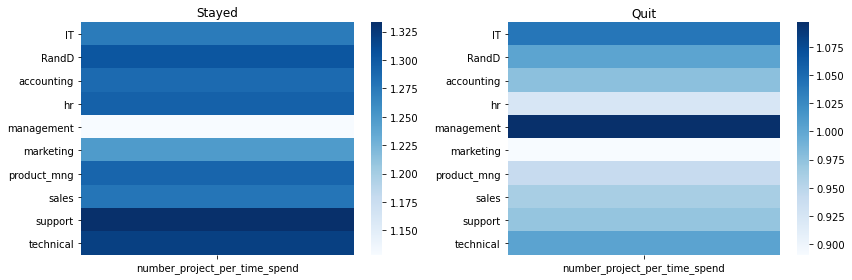

In [309]:
plt.figure(figsize=(12,4))
# Heatmap for those who are still employed.
plt.subplot(121)
sns.heatmap(projec_per_0, cmap='Blues')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Stayed')
# Heatmap for those who have left their jobs.
plt.subplot(122)
sns.heatmap(projec_per_1, cmap='Blues')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Quit')
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The deserters tend to have a slightly lower average amount of projects during their tenure.
        </li>
    </ul>
</div>